# Exploratatory Analysis of the GECKO-A data set

Before we can apply any machine learning techniques, we must gather, prepare and explore the data available. Data is almost always presented in a way that makes building a model difficult if not impossible. This can be due to missing data, incorrect data types, variability in values between features that make modeling difficult, or any other number of reasons. We're going to start with loading the dataset. Then we will do some initial analysis of the data. How is it typed? What is the [Tukey 5-number Summary](https://machinelearningmastery.com/how-to-calculate-the-5-number-summary-for-your-data-in-python/#:~:text=The%20five%2Dnumber%20summary%2C%20or,for%20data%20with%20any%20distribution.)? How is the data distributed? Are the data in the features correlated? Then we move on to how we can scale and normalize the data to better help our algorithms solve for a model that can hopefully generalize well.

## Gathering the data

Data can be stored in a variety of ways with varying complexities and advantages. One very common way of storing data is as a csv file. CSV has the advantage of being human readable and easily accessible by a large variety of applications, but with the caveat that csv files do not necessarily distinguish between text and numeric data. Data is also not typed so you cannot assume your application will automatically be able to distinguish between int, float, bool, text, etc.

We will begin by loading a csv file into a pandas data frame. This will make it easier to explore the data as well as set the type for each column of data.

GECKO-A runs simulations of precursors under a variety of different conditions for 5 days at 5 minute increments. It would be overwhelming to start with a large dataset so we will start by only loading experiment 1000 for the toluene precursor.

**Note I want to ask about what DJ and John would like me to start with. Should I start with raw data or maybe just a single csv and doctor it up a little to run through changing data type and such in the tutorial?**
**Note that in the future I am going to want to implement a way to publicly retrieve this data. Also it may be stored in the parquet format rather than csv**

In [70]:
# We will need several popular data science tools for this notebook
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import sklearn
import sklearn.decomposition
import scipy
from sklearn.metrics import mean_squared_error
import seaborn as sns

%matplotlib inline

In [2]:
file_path = "/glade/p/cisl/aiml/gecko/ML2019_toluene_postproc_NEW/ML2019_toluene_ML2019_Exp1000.csv"

We can load the data using pandas built-in "read_csv" function and take a peek using the pd.head() function. 

In [3]:
dataFrame = pd.read_csv(file_path)
dataFrame.head()

,Time [s],Precursor [ug/m3],Temperature [K],OH [molec/cm3],O3 [molec/cm3],NOx [molec/cm3],SZA [degree],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,...,N/C Bin05: lg(C*) = -2.5,N/C Bin06: lg(C*) = -1.5,N/C Bin07: lg(C*) = -0.5,N/C Bin08: lg(C*) = 0.5,N/C Bin09: lg(C*) = 1.5,N/C Bin10: lg(C*) = 2.5,N/C Bin11: lg(C*) = 3.5,N/C Bin12: lg(C*) = 4.5,N/C Bin13: lg(C*) = 5.5,N/C Bin14: lg(C*) = 6.5
0,1.000000,0.037689,298.179718,2634522.0,2.865347e+12,1.738747e+10,156.839686,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,301.207794,0.037522,298.179718,2634522.0,2.865347e+12,2.857613e+11,156.845342,1.437334e-17,1.239800e-12,5.477925e-13,...,0.276480,0.196323,0.146863,0.211432,0.079300,0.143338,0.010915,0.137913,0.080868,0.000905
2,601.415588,0.037355,298.092407,2634522.0,2.865347e+12,5.082960e+11,156.787255,1.273297e-17,1.094499e-12,4.821359e-13,...,0.278963,0.139626,0.038531,0.229156,0.093255,0.146419,0.032462,0.137106,0.051741,0.001997
3,901.623352,0.037189,298.005127,2634522.0,2.865347e+12,6.930831e+11,156.665902,1.144432e-17,9.674742e-13,4.288795e-13,...,0.281173,0.080940,0.038050,0.244181,0.098729,0.151842,0.056919,0.136595,0.040094,0.003167
4,1201.831177,0.037024,297.917938,2634522.0,2.865347e+12,8.467239e+11,156.482265,1.085807e-17,8.611497e-13,3.972799e-13,...,0.282642,0.058053,0.046640,0.258280,0.101695,0.159428,0.079230,0.136029,0.035332,0.004402


Already we can see what columns are included in the data and get an idea of variablity in scale. Let's do some further formal investigation.

To see all the info available about a data frame you can use the built-in info function. We can see that all the data is fortuntately typed as float data. 

In [4]:
# Uncomment to see info about this dataframe
#dataFrame.info(verbose=True)

A really simple way to get idea of scale of date is to compute the mean and variance of the columns with which you are working.

In [5]:
mean_list = [dataFrame[x].mean() for x in dataFrame]
variance_list = [dataFrame[x].var(ddof=1) for x in dataFrame]

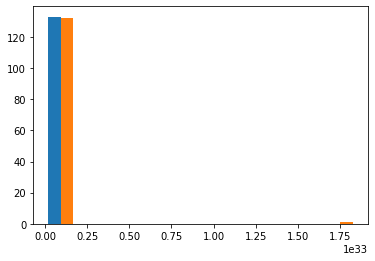

In [6]:
_ = plt.hist([mean_list,variance_list]);
plt.show()

We can so far see that there are 133 features in this matrix of data, there are 1440 time steps and the data is not well distributed at all.

There are a few ways we can distribute the data a little better. It's much easier to work with something that follows somewhat of a gaussian distribution. Like the following distribution with a mean of 0 and a variance of 1:

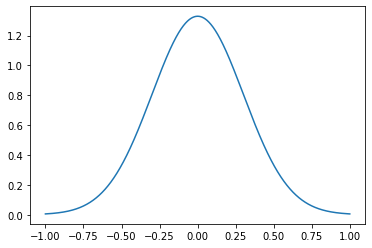

In [7]:
x_axis = np.arange(-1, 1, 0.001)
plt.plot(x_axis, stats.norm.pdf(x_axis,0,0.3))
plt.show()

## Data Preparation: Normalizing data

It's important to normalize and scale data because it makes it easier to solve for a local minima when evaluating the surface of the cost function for our model using gradient descent. Think of normalizing as smoothing the surface of the cost function. More information on scaling and normalizing [here.](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35#:~:text=Feature%20scaling%20is%20essential%20for,that%20calculate%20distances%20between%20data.&text=Since%20the%20range%20of%20values,not%20work%20correctly%20without%20normalization.)

### A visual of scaling effects

We're going to randomly draw 30 columns from our data frame and plot that data in a histogram.

In [8]:
np.random.seed(1234)
sample = np.random.choice(dataFrame.columns, size = 30)

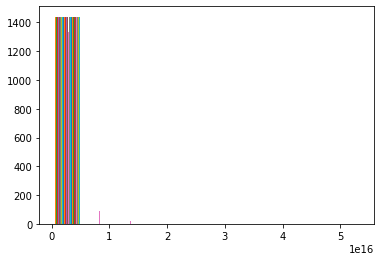

In [9]:
sampled_data = dataFrame.loc[:,sample]
_ = plt.hist(sampled_data)

You can see from the histogram that the data is not well distributed and the variance is very large. We can apply a scaling method that will compute the mean and variance of each individual column. Then we can transform our data by fitting that standardization to each column.

In [10]:
scaler = StandardScaler()

# Computed mean and standard deviation for each column
scaler  = scaler.fit(sampled_data)

# Applies a standarization to each column of data for the matrix shaped n_samples by n_features
sampled_data_scaled = scaler.transform(sampled_data)

Now if we plot the data we get a distribution that more closely resembles a standard normal distribution.

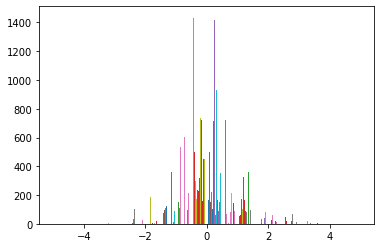

In [11]:
_ = plt.hist(sampled_data_scaled, bins = 20, range = [-5,5])

This is only one type of standardization method called Z-score standardization and is represented in the following way:

$x' = \frac{x - \bar{x}}{\sigma}$ , where ${x}$ is the original feature vector, ${\bar {x}}={\text{average}(x)}$ is the mean of that feature vector, and ${\displaystyle \sigma }$ is its standard deviation.

There are many other types of scaling and normalization techniques.

### Correlation Matrix

Now that we know some scaling methods we can go ahead and expand our data frame to include other experiments and do some further exploration by building a correlation matrix. This will help us determine what features my be linear combinations of other features. There is a technique called Principal component analysis that we can use to reduce the dimension of our data by abstracting away linearly correlated data. First lets build our dataset...

### Building our dataset

There is data from thousands of experiments but we will start with 2000 experiments. Each experiment contains 1440 rows of data so our dataset will contain about 2.9 million rows of data and be size 2,880,000 by 133, this will equate to about 4 GB of data so plan on leaving between 25 and 30 minutes to load this.

**Note this will have to be a publically available source in the future. Can change filepath parameter**

In [31]:
def load_data(start_index=0, end_index=2000):
    dataFrame = pd.DataFrame()
    progress = 0
    for index in range(start_index, end_index):
        file_path = f"/glade/p/cisl/aiml/gecko/ML2019_toluene_postproc_NEW/ML2019_toluene_ML2019_Exp{str(index)}.csv"
        dataFrame = dataFrame.append(pd.read_csv(file_path))
        progress += 1
        if progress % 100 == 0:
            print(progress, "experiments loaded")
    return dataFrame

This is going to take awhile...

In [32]:
dataFrame = load_data()

100 experiments loaded
200 experiments loaded
300 experiments loaded
400 experiments loaded
500 experiments loaded
600 experiments loaded
700 experiments loaded
800 experiments loaded
900 experiments loaded
1000 experiments loaded
1100 experiments loaded
1200 experiments loaded
1300 experiments loaded
1400 experiments loaded
1500 experiments loaded
1600 experiments loaded
1700 experiments loaded
1800 experiments loaded
1900 experiments loaded
2000 experiments loaded


We can save time by just saving our dataFrame as a parquet file for next time we want to load it. This takes seconds to read and write vs minutes to build the dataframe each time.

In [63]:
dataFrame.columns

Index([' Time [s]', ' Precursor [ug/m3]', ' Temperature [K]',
       ' OH [molec/cm3]', ' O3 [molec/cm3]', ' NOx [molec/cm3]',
       ' SZA [degree]', ' Gas [ug/m3] Bin01: lg(C*) = -6.5',
       ' Gas [ug/m3] Bin02: lg(C*) = -5.5',
       ' Gas [ug/m3] Bin03: lg(C*) = -4.5',
       ...
       ' N/C Bin05: lg(C*) = -2.5', ' N/C Bin06: lg(C*) = -1.5',
       ' N/C Bin07: lg(C*) = -0.5', ' N/C Bin08: lg(C*) =  0.5',
       ' N/C Bin09: lg(C*) =  1.5', ' N/C Bin10: lg(C*) =  2.5',
       ' N/C Bin11: lg(C*) =  3.5', ' N/C Bin12: lg(C*) =  4.5',
       ' N/C Bin13: lg(C*) =  5.5',
       ' N/C Bin14: lg(C*) =  6.5                                                                                                      '],
      dtype='object', length=133)

Notice there is a space before every column name. Let's get rid of that.

In [64]:
rename_columns = {}
for column in dataFrame.columns:
    rename_columns[column] = column[1:]
    
dataFrame = dataFrame.rename(columns=rename_columns)

In [65]:
# Save dataFrame containing experiments 0 through 1999 to parquet file
dataFrame.to_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999.parquet")

In [46]:
# To read just use pd.read_parquet()
# dataFrame = pd.read_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999.parquet")

### Correlation

In [67]:
# We can remove the time domain before constructing a correlation matrix
dataFrame_corr = dataFrame.drop(columns = ["Time [s]"])

In [68]:
corr_mat = dataFrame_corr.corr(method='pearson')
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

NameError: name 'sns' is not defined

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

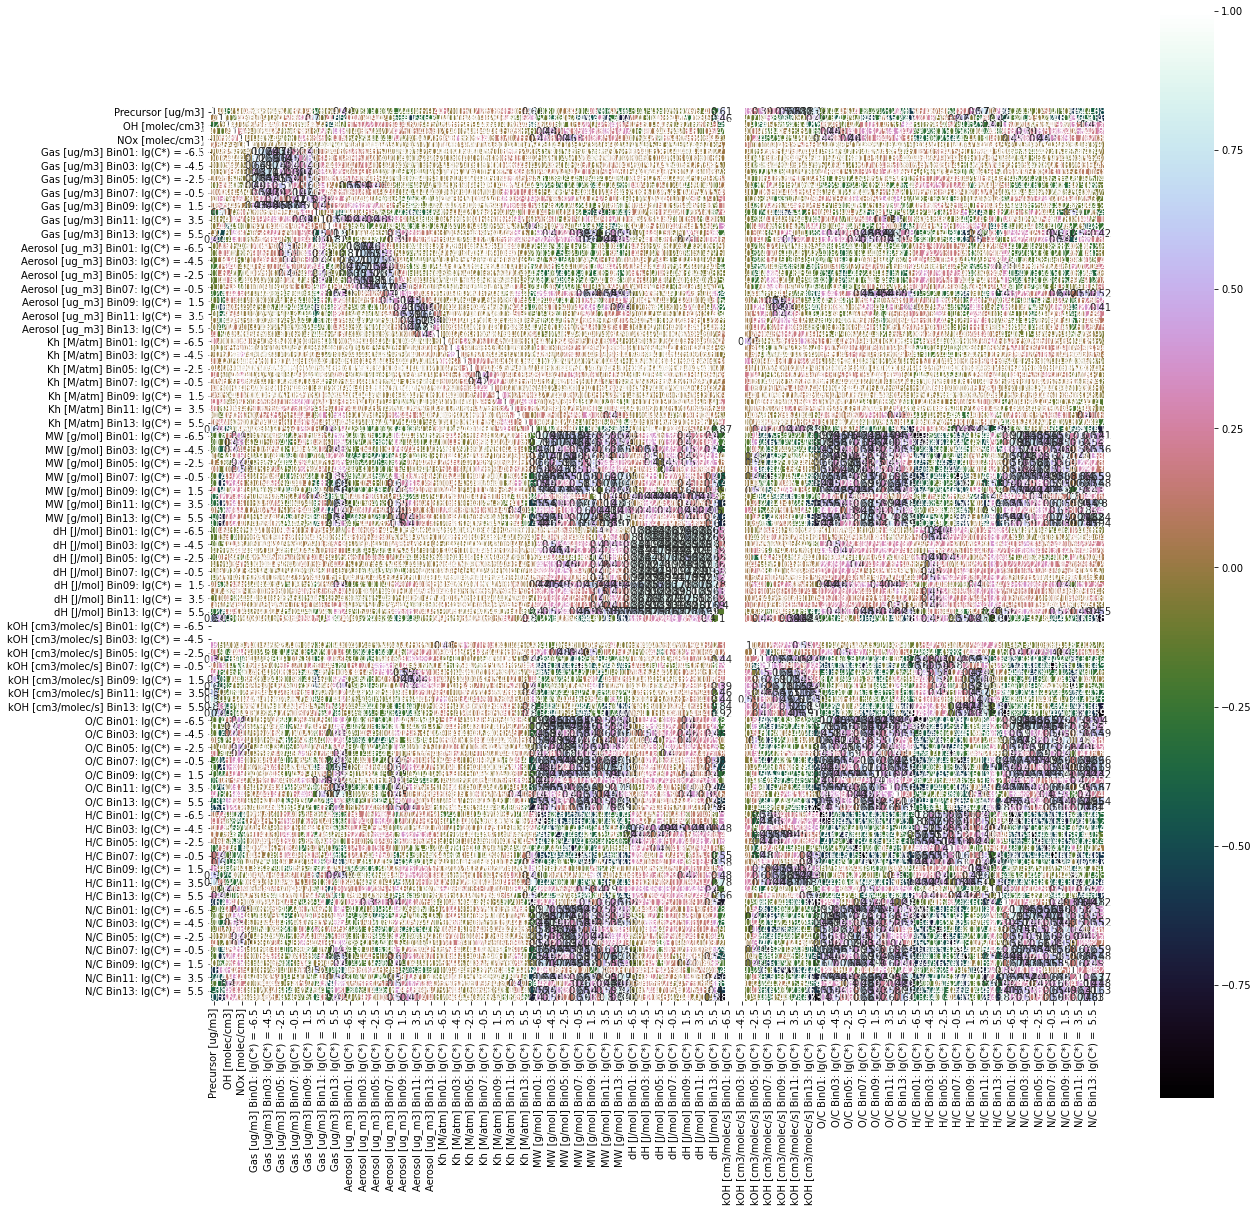

In [72]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

In [152]:
dataFrameArray = dataFrame.loc[::].values

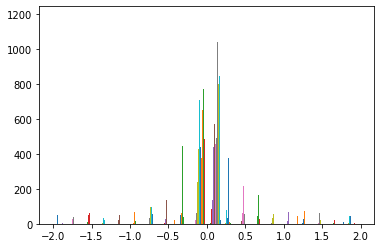

In [153]:
pca = sklearn.decomposition.PCA(n_components=132)
pca.fit(dataFrameArray)
X = pca.transform(dataFrameArray)
_ = plt.hist(X, range = [-2,2], bins = 20)

## Constructing a basic linear model

So far we have peeked at the data and applied two scaling techniques. Let's construct a very basic model to predict precursor at t+n where t is the previous timestep and n represent the lead time. Lead time being t_delta between observation and prediction.


For our model we are give a matrix of predictors **X** and a vector of **y**. We are trying to solve for model *w* which minimizes the following:

$$\text{min}||Xw-y||^2 $$

There will me more on this later. Let's just abstract away model building for now so we can see the importance of feature scaling and normalization.

The general steps here will be.

*Step 1*: Build X and y

*Step 2*: Separate data into a training set, valuation set, and test set. (There is a bit of technique in this, but we will make this simple for now.)

*Step 3*: Use the training set to develop a model that will generalize to the valuation set. 

*Step 4*: Apply changes as necessary to avoid underfitting and overfitting. (More on this later.)

*Step 5*: Apply your model to the test set.

### Helper

In [155]:
def plot_GECKO_time_series(y, y_predictions, title):
    """
    notes
    -----
        Taken from seasonal_forecasting.ipynb notebook. Credit: Charlie Becker

    inputs
    ------
        y             pd.array  : time series of the true precursor amount
        predictions   np.array  : time series of the predicted values for y (same
                                  length and time as y)
        title                   : the title of the plot

    outputs
    -------
        None.  Displays the plot
    """
#     predictions = pd.Series(y_predictions, index=y.index)
#     predictions = predictions.sort_index()
#     y = y.sort_index()

    plt.plot(y, label='Ground Truth')
    plt.plot(y_predictions, '--', label='ML Predictions')
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel('Precursor [ug/m3] ')
    plt.xlabel('Time-step')
    plt.show()
    plt.close()

### Step 1: Build X and y

In [ ]:
def assemble_predictors_predictands(start_index, end_index, lead_time, dataFrame):
    X = dataFrame.iloc[start_index:end_index,1:].values
    y = dataFrame.loc[start_index + lead_time: end_index + lead_time - 1,' Precursor [ug/m3]'].values
    #TODO
    # Add logic to make sure dataframe is not being overindexed when building vector of predictands
    
    """
    notes
    -----
        Taken from seasonal_forecasting.ipynb notebook. Credit: Charlie Becker
        We will ignore the time domain in our feature matrix.
        
    inputs
    ------

        start_index       int : the start index from which to extraxt features
        end_index         int : the end index
        lead_time         int : (n) the number of timesteps between each row of features
                              and the target amount of precursor

    outputs
    -------
        Returns a tuple of the predictors (np array of predictive features) 
        and the predictands (np array of precursor at t+n).
        """

    return X,y

In [185]:
X,y = assemble_predictors_predictands(start_index = 0, end_index = 1390, lead_time = 1, dataFrame = dataFrame)

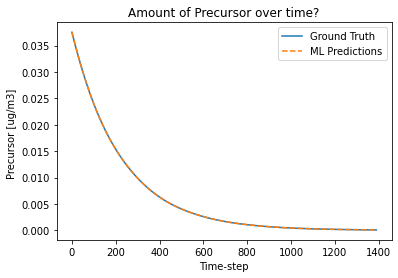

In [186]:
plot_GECKO_time_series(y,y,"Amount of Precursor over time?")

### Step 2: Separate data into a training set, valuation set, and test set. (There is a bit of technique in this, but we will make this simple for now.)

We are going to allocated about 55% of the lower half of data for training, 65-75% will be for valuation, and 85-95% for test set. This will be approximate separations going by index. There are other methods for creating sets but this will be covered in a later notebook.

In [173]:
for i in [1440 * 0.55, 1440 * 0.65, 1440 * 0.75, 1440 * 0.85, 1440 * 0.95]:
    print(int(i))

792
936
1080
1224
1368


In [183]:
X_train, y_train = assemble_predictors_predictands(start_index=0, end_index=1300, lead_time=1, dataFrame=dataFrame)
X_val, y_val = assemble_predictors_predictands(start_index=936, end_index=1080, lead_time=1, dataFrame=dataFrame)
X_test, y_test = assemble_predictors_predictands(start_index=1224, end_index=1368, lead_time=1, dataFrame=dataFrame)

### *Step 3*: Use the training set to develop a model that will generalize to the valuation set. 

RMSE: 0.00


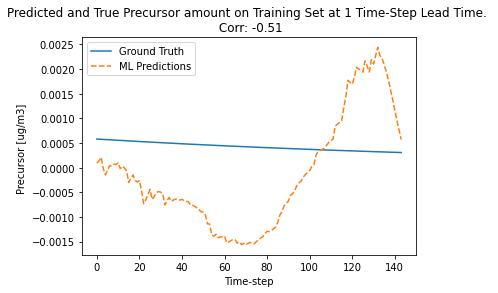

In [184]:
#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_GECKO_time_series(y_val, predictions, 
    'Predicted and True Precursor amount on Training Set at 1 Time-Step Lead Time. \n Corr: {:.2f}'.format(corr))

## Moving on to larger dataset